In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

from colorama import Fore, Style

%matplotlib inline

In [2]:
df = pd.read_csv('datas/critiques_star_wars_7.csv')

# Partie 1 : Quelques statistiques sur les données

In [3]:
df.head()

,auteur,note,date,critique
0,Johan Gendry,"5,0",2020-04-11 00:00:00,\n En 3 jours je me suis ...
1,Damianous,"3,0",2020-04-01 00:00:00,\n Ça commence plutôt bie...
2,Lilian Bernabeu,"1,5",2020-03-30 00:00:00,\n Bon je vais faire en s...
3,FaulKeuR,"3,5",2020-03-22 00:00:00,\n J. J. Abrams a eu la l...
4,Lin Guini,"1,0",2020-03-20 00:00:00,\n Pire idée de suite. Gâ...


In [4]:
df.describe() # quelques informations sur les features

,auteur,note,date,critique
count,4595,4595,4595,4595
unique,4259,10,557,4591
top,Un visiteur,"0,5",2015-12-26 00:00:00,\n Un septième opus spect...
freq,99,598,279,2


In [5]:
# conversion des notes en entier
df['note'] = df['note'].apply(lambda x: x.replace(',', '.')).apply(lambda x: float(x))

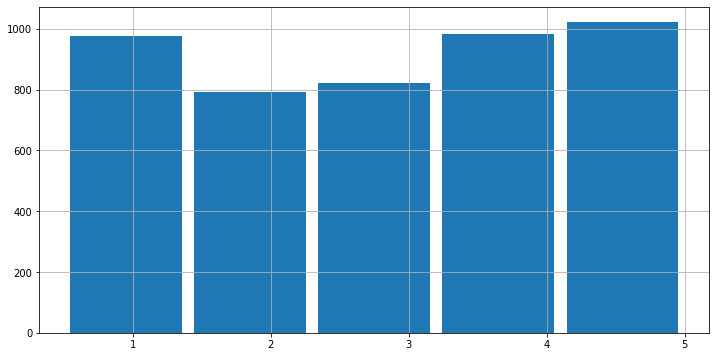

In [6]:
df['note'].hist(bins=5, figsize=(12,6), rwidth=0.9)

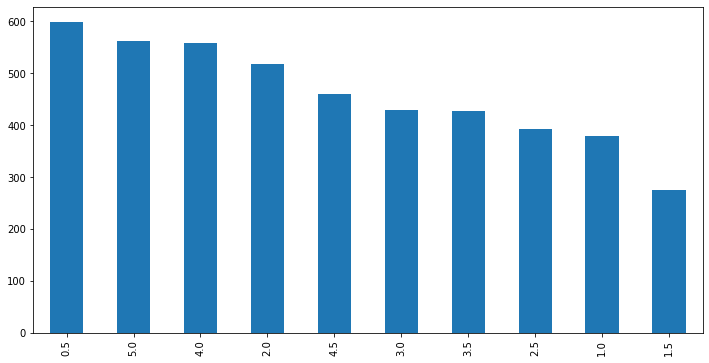

In [7]:
# distribution des notes
df['note'].value_counts().plot(kind='bar', figsize=(12,6))

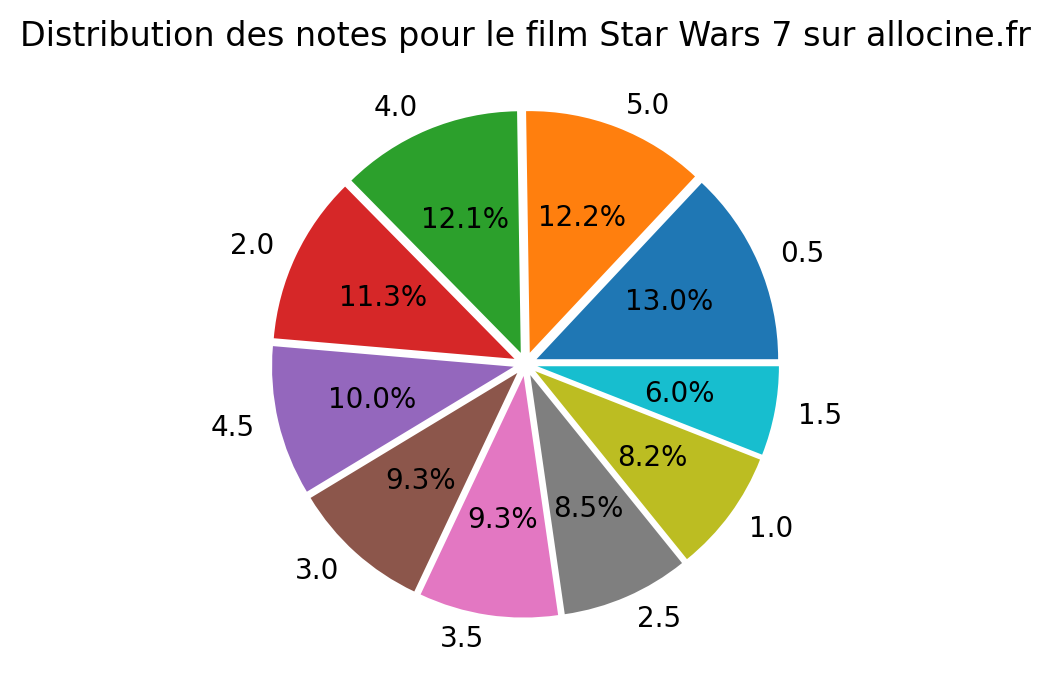

In [8]:
# Pie charts
notes_cat = list(df['note'].value_counts().index)
notes_distrib = df['note'].value_counts().values

plt.figure(figsize=(4,4), dpi=200)
plt.title('Distribution des notes pour le film Star Wars 7 sur allocine.fr')
plt.pie(notes_distrib, labels=notes_cat, explode=[float(0.05) for i in range(10)], autopct='%1.1f%%')
plt.show()

In [9]:
print("Moyenne des notes de star wars 7 (pour les personnes qui ont postées) :", round(df['note'].mean(), 1))
# le site indique 3.5/5 pour l'ensemble des notes

Moyenne des notes de star wars 7 (pour les personnes qui ont postées) : 2.8


In [10]:
# conversion de la date en objet datetime
df['date'] = pd.to_datetime(df['date'])

In [11]:
# time series
df.set_index('date', inplace=True)

In [12]:
# du plus ancien commentaire au plus récent
df.sort_index(inplace=True)

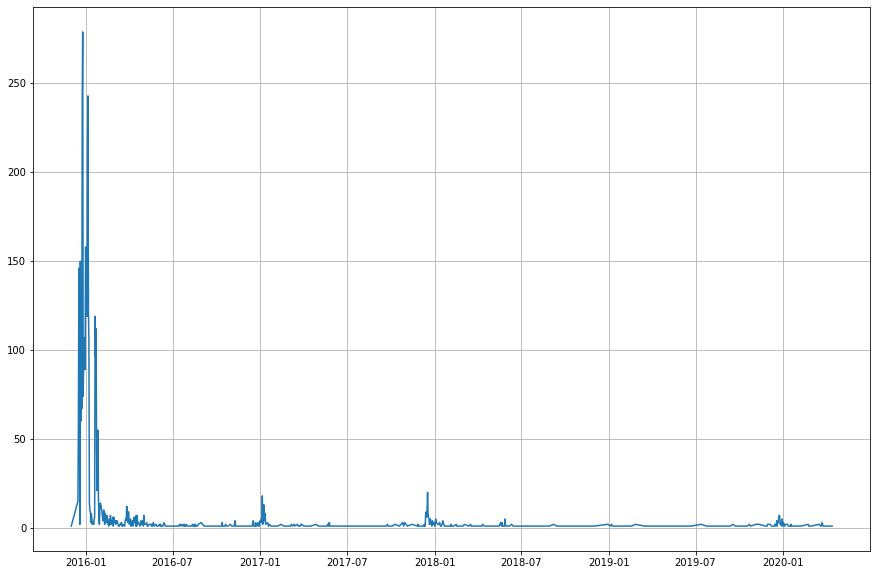

In [13]:
df.groupby(df.index.date).count()['note'].plot(figsize=(15,10), grid=True)

On remarque que l'essentiel des critiques se concentrent lors de la sortie du film. On observe également un pic d'activité lors de la sortie des deux films suivants Star Wars 8 (décembre 2017) et Star Wars 9 (décembre 2019) ainsi qu'au moment de la sortie des films dérivés de l'univers star wars (Rogue One et Solo, respectivement en décembre 2016 et mai 2018).

In [14]:
d = df.groupby(df.index.date).count()['note'].idxmax().strftime('%A, %d/%m/%Y')
print('Jour du plus grand nombre de commentaires postés :', d)
print(df.groupby(df.index.date).count()['note'].max(), 'commentaires')

Jour du plus grand nombre de commentaires postés : Saturday, 26/12/2015
279 commentaires


In [15]:
# 10 visiteurs qui ont posté le plus de critiques (noms génériques)
df['auteur'].value_counts().head(10)

Un visiteur     99
Thomas C.        6
Alexandre D.     5
Romain M.        5
Nicolas B.       5
Nicolas T.       4
Romain S.        4
Olivier M.       4
Alexandre L.     4
Alex C.          4
Name: auteur, dtype: int64

# Partie 2 : Natural Language Processing

## Préparation des données

In [16]:
# affichage d'une critique
random_critique = df['critique'][45]
print(random_critique)


                      Le "vrai" ADN de la saga initiale, avec les moyens d'aujourd'hui (voir de demain). Un casting au top. indispensable.
        
            


In [17]:
def strip_text(text):
    return text.lstrip('\n                      ').rstrip('\n        \n            ')

In [18]:
df['critique'] = df['critique'].apply(strip_text)

In [19]:
print(df['critique'][45])

Le "vrai" ADN de la saga initiale, avec les moyens d'aujourd'hui (voir de demain). Un casting au top. indispensable.


Création de la **feature** `sentiment` basée sur la note :
- 0 équivaut à un sentiment positif
- 1 à un sentiment négatif

In [20]:
def create_sentiment(note):
    
    # sentiment négatif == 1
    if note in [0.5,1,1.5,2]:
        return 1
    
    # sentiment positif == 0
    else:
        return 0

In [21]:
df['sentiment'] = df['note'].apply(create_sentiment)

In [22]:
# on remet l'index numérique
df.reset_index(inplace=True)

In [23]:
df.head()

,date,auteur,note,critique,sentiment
0,2015-12-02,Un visiteur,0.5,Un nouvel opus pas touchant et plein de maladr...,1
1,2015-12-16,JeanSéééééé,3.5,Tous les nouveaux personnages sont excellents ...,0
2,2015-12-16,Rainfall_Shadow,5.0,"Fermez les yeux, réveillez vous 30 ans après l...",0
3,2015-12-16,Damien D,1.5,Ce film est tous simplement un film d action. ...,1
4,2015-12-16,pastorey B.,0.5,"aprés la grosse banane de la menace fantome , ...",1


In [24]:
# on import les stopwords de NLTK
french_stopwords = set(stopwords.words('french'))

In [25]:

vectorizer = CountVectorizer(stop_words=french_stopwords)

In [26]:
all_features = vectorizer.fit_transform(df['critique'])

In [27]:
all_features.shape

(4595, 26800)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(all_features, df['sentiment'], test_size=0.2, random_state=42)

In [29]:
X_train.shape

(3676, 26800)

In [30]:
X_test.shape

(919, 26800)

## Classification avec Naive Bayes

In [31]:
classifier = MultinomialNB()

In [32]:
classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
predictions = classifier.predict(X_test)

In [34]:
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       577
           1       0.81      0.73      0.77       342

    accuracy                           0.84       919
   macro avg       0.83      0.81      0.82       919
weighted avg       0.83      0.84      0.83       919

[[517  60]
 [ 91 251]]


In [35]:
nb_correct = (y_test == predictions).sum()
print('Nombre de bonnes prédictions', nb_correct)

Nombre de bonnes prédictions 768


In [36]:
nb_incorrect = y_test.size - nb_correct
print('Nombre de mauvaises prédictions', nb_incorrect)

Nombre de mauvaises prédictions 151


In [37]:
fraction_wrong = nb_incorrect / (y_test.size)
print(f'La précision du modèle est de {1-fraction_wrong:.2%}')

La précision du modèle est de 83.57%


## Test avec des commentaires fictifs (*sentiment analysis*)

In [38]:
# on génère des commentaires fictifs
commentaires = ["Ce film est nul ! C'est le plus mauvais film que j'ai vu depuis longtemps. Aucun intérêt. Une sombre daube",
               "Ce film est génial, c'est le meilleur Star Wars. Super film, j'ai adoré !",
              "C'est un très très bon star wars, j'ai beaucoup aimé ce film, il est génial, les personnages sont excellents.",
              "C'est le pire film de l'année, une vraie bouse, médiocre. Un film débile, j'ai détesté !"]

In [39]:
# on vectorise les commentaires pour la prédiction
doc_term_matrix = vectorizer.transform(commentaires)

Ici, une boucle nous permettra des tester nos commentaires. Les critiques positives sont affichées en `vert`, les critiques négatives en `rouge`.

In [40]:
for result, commentaire in zip(classifier.predict(doc_term_matrix), commentaires):
    if result == 1:
        commentaire = Fore.RED + '[-] ' + commentaire + Style.RESET_ALL
    else:
        commentaire = Fore.GREEN + '[+] ' + commentaire + Style.RESET_ALL
    print(commentaire)

[-] Ce film est nul ! C'est le plus mauvais film que j'ai vu depuis longtemps. Aucun intérêt. Une sombre daube
[+] Ce film est génial, c'est le meilleur Star Wars. Super film, j'ai adoré !
[+] C'est un très très bon star wars, j'ai beaucoup aimé ce film, il est génial, les personnages sont excellents.
[-] C'est le pire film de l'année, une vraie bouse, médiocre. Un film débile, j'ai détesté !


## Examen des critiques mal classées

In [41]:
nbr_crit = y_test.size
print('Nombre de critiques dans notre jeu d\'entraînement :', nbr_crit)

Nombre de critiques dans notre jeu d'entraînement : 919


In [42]:
nbr_crit_pos = y_test[y_test == 0].size
print(f'Nombre de critiques positives dans notre jeu d\'entraînement:\
\t{nbr_crit_pos}\t{nbr_crit_pos/nbr_crit:.0%}')

Nombre de critiques positives dans notre jeu d'entraînement:	577	63%


In [43]:
nbr_crit_neg = y_test.sum()
print(f'Nombre de critiques négatives dans notre jeu d\'entraînement:\
\t{nbr_crit_neg}\t{nbr_crit_neg/nbr_crit:.0%}')

Nombre de critiques négatives dans notre jeu d'entraînement:	342	37%


### Examen des critiques négatives classées comme postives

In [44]:
nbr_crit_neg_mal_clas = df.loc[y_test[(y_test == 1) & (predictions == 0)].index].sum()['sentiment']
print(f"{nbr_crit_neg_mal_clas} critiques négatives sont mal classées \
({nbr_crit_neg_mal_clas/nbr_crit_neg:.2%})")

91 critiques négatives sont mal classées (26.61%)


On peut voir en détail quelles sont les critiques mal classées en fonction de leur note originelle

In [45]:
df.loc[y_test[(y_test == 1) & (predictions == 0)].index]['note'].value_counts()

2.0    48
1.0    18
1.5    16
0.5     9
Name: note, dtype: int64

Plus de la moitié des commentaires négatifs mal classés sont les commentaires ayant recueillis la note de **2/5**. C'est assez logique, ce sont les moins péjoratifs donc les plus difficiles à classer, que ce soit pour un humain ou un algorithme.

In [46]:
df.loc[y_test[(y_test == 1) & (predictions == 0)].index]['note'].value_counts() / y_test.sum()

2.0    0.140351
1.0    0.052632
1.5    0.046784
0.5    0.026316
Name: note, dtype: float64

On remarque également que **14%** des critiques ayant eu la note de **2/5** sont mal classées. En revanche seulement **2.6%** des critiques les plus négatives **0.5/5** sont considérées comme positives.

In [47]:
# on récupère l'index des 9 critiques négatives notées 0.5/5 classées comme positives
false_negatives = df.loc[y_test[(y_test == 1) & (predictions == 0)].index]
index_false_neg = false_negatives[false_negatives['note'] == 0.5].index

In [48]:
for index in index_false_neg:
    print(index, ':', df.iloc[index]['critique'])
    print('*' * 100)

3052 : Ni puriste, ni indifférent, j'ai trouvé ce nouvel opus gâché par son scénario !
La réalisation elle n'est pas trop mal, l'univers est respecté.
Je n'ai aimé pratiquement aucun jeux d'acteur sauf certains qui étaient déjà présent dans les anciens. Le pire de tous reste l'interprète de Kylo Ren. Quand à Rey et Finn, ce n'est pas qu'ils sont mauvais mais ils n'ont pas réussi à me toucher. Oscar Isaac relève un peu le niveau.
Ce que je n'ai pas aimé non plus est la non crédibilité de certaines scènes et surtout la relation d'un certain personnage avec la force (mais je vous laisse découvrir par vous même).
Conclusion : l'histoire est vraiment ce qui m'a fait le plus detester ce film suivi de l'erreur de casting.
****************************************************************************************************
3728 : Pour résumer,

Si vous n'avais JAMAIS vu Star Wars, vous allez aimer ce film.
Si vous avez entre 3 et 13 ans, vous allez aimer ce film.
Si vous aimez ne pas réfléchir 

On remarque que certaines critiques, notamment la **4568** sont difficiles à classer car leurs auteurs utlisent l'ironie et donc des termes mélioratifs pour exprimer un sentiment négatif. L'algorithme Naive Bayes classe les critiques en fonction de la présence de certains termes : si ces termes sont davatange présents dans les critiques positives, alors il en déduira que la critique est positive. Une utilisation de termes mélioratifs fera que la critique sera statistiquement considérée comme étant positive.

### Examen des critiques positives classées comme négatives

In [49]:
nbr_crit_pos_mal_clas = df.loc[y_test[(y_test == 0) & (predictions == 1)]].shape[0]
print(f"{nbr_crit_pos_mal_clas} critiques positives sur {nbr_crit_pos} sont mal classées \
({nbr_crit_pos_mal_clas/nbr_crit_pos:.2%})")

60 critiques positives sur 577 sont mal classées (10.40%)


In [50]:
df.loc[y_test[(y_test == 0) & (predictions == 1)].index]['note'].value_counts()

2.5    30
3.0    13
3.5    10
5.0     3
4.5     2
4.0     2
Name: note, dtype: int64

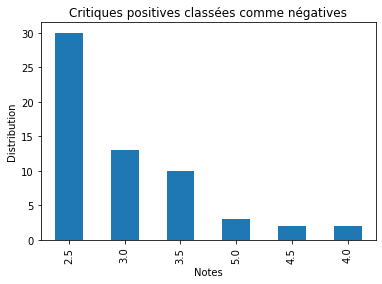

In [51]:
# on peut localiser les critiques et afficher un histogramme
plt.title('Critiques positives classées comme négatives')
plt.xlabel('Notes')
plt.ylabel('Distribution')
df.loc[y_test[(y_test == 0) & (predictions == 1)].index]['note'].value_counts().plot(kind='bar')

In [52]:
df.loc[y_test[(y_test == 0) & (predictions == 1)].index]['note'].value_counts() / nbr_crit_pos_mal_clas

2.5    0.500000
3.0    0.216667
3.5    0.166667
5.0    0.050000
4.5    0.033333
4.0    0.033333
Name: note, dtype: float64

De la même manière, on observe que les critiques positives les moins bien classées sont celles ayant obtenues la note de **2.5/5**. Ce sont les "moins bonnes" des critiques positives et donc celles les plus susceptibles d'utiliser des termes péjoratifs.

In [53]:
# on affiche les 3 critiques 5/5 mal classées

false_positives = df.loc[y_test[(y_test == 0) & (predictions == 1)].index]
index_false_pos = false_positives[false_positives['note'] == 5].index

In [54]:
for index in index_false_pos:
    print(index, ':', df.loc[index]['critique'])
    print('*' * 100)

3807 : Bonjour je voudrais juste dire à ceux qui mette des critique aussi horrible a mettre même une étoile il dise n'importe quoi il connaisse rien sur star wars il sont rien comprit vous il ďisent que c la même histoire que dans le 4/5/6 oui je suis d'accord avec sa mais pas complètement par ce que moi je dis que c la suite de l'histoire c pas de la pareille c juste la suite de l'histoire moi je trouve qu'il étais cool de film il était superbes et en plus à ce qui dise que c'était nul l'épisode 8 sera mieux par ce que j'ai vue qu'il vont changer l'histoire sa va pas être pareille comme vous dites donc aller le regarder il sera mieux je vous le promet . Moi j'ai adorée se film touts était bien fait je suis encore une fois fan de cette épisode 7 touts et bien joué je met les 5etoiles je donnerais 100/100 pour se film j'adore les personnages qui joue dedant et touts .merci d'avoir lu ma critiques
*******************************************************************************************

On remarque une chose intéressante ici c'est que l'algorithme a correctement classée une critique positive comme étant négative. En effet la critique **4593** est négative mais a été notée positivement par son auteur (sûrement une erreur de l'auteur au moment de la saisie de la note). Quant aux deux autres critiques, il s'agit de critiques dans lesquelles leurs auteurs défendent leur point de vue et s'en prennent aux *haters* et donc utilisent des termes péjoratifs pour désigner ces derniers. Les termes péjoratifs classent donc la critique dans la catégorie négative.

In [55]:
# par sécurité, on vérifie que la critique 4593 est bien notée 5/5
df.iloc[4593]['note']

5.0

## Classification avec SVM

In [56]:
from sklearn.svm import SVC

In [57]:
svc = SVC(kernel='linear', C=5)

In [58]:
svc.fit(X_train, y_train)

SVC(C=5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [59]:
svc_predictions = svc.predict(X_test)

In [60]:
print(classification_report(y_test, svc_predictions))
print(confusion_matrix(y_test, svc_predictions))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       577
           1       0.71      0.71      0.71       342

    accuracy                           0.78       919
   macro avg       0.77      0.77      0.77       919
weighted avg       0.78      0.78      0.78       919

[[478  99]
 [100 242]]


## Avec GridSearchCV

In [61]:
from sklearn.model_selection import GridSearchCV

In [62]:
parameters = {'C':[i for i in range(1, 20)]}

In [63]:
parameters

{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}

In [64]:
clf = GridSearchCV(svc, parameters, cv=2)

In [65]:
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=SVC(C=5, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='linear', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                               15, 16, 17, 18, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [66]:
print(clf.best_params_) # on relance svc avec C=1 en paramètre

{'C': 1}


In [67]:
svc = SVC(kernel='linear', C=1)
svc.fit(X_train, y_train)
svc_predictions = svc.predict(X_test)
print(classification_report(y_test, svc_predictions))
print(confusion_matrix(y_test, svc_predictions))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       577
           1       0.71      0.71      0.71       342

    accuracy                           0.78       919
   macro avg       0.77      0.77      0.77       919
weighted avg       0.78      0.78      0.78       919

[[477 100]
 [100 242]]


Avec un meilleur `paramètre` C, on obtient un plus mauvais résultat (1 bonne prédiction en moins).